In [89]:
import itertools
import random
from typing import Tuple
import wave
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torchaudio.transforms as T
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader, Subset
import math, random
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import pdb
import pandas as pd
import torchaudio.transforms
import torch
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew

In [209]:
# Retrieve dataset
df = pd.read_pickle("df_final.pkl")
df = df[df.intensity != 0]
df = df.reset_index()
df

,index,audio,intensity
0,1,"[[tensor(-0.7592), tensor(-0.8084), tensor(-0....",95.076299
1,2,"[[tensor(-0.0686), tensor(-0.0764), tensor(-0....",70.015840
2,3,"[[tensor(-1.0000), tensor(-1.0000), tensor(-1....",67.107005
3,4,"[[tensor(-0.0646), tensor(-0.0725), tensor(-0....",4.039027
4,6,"[[tensor(0.6123), tensor(0.6109), tensor(0.583...",58.398384
...,...,...,...
7783,9729,"[[tensor(-0.1500), tensor(-0.1235), tensor(-0....",7.819445
7784,9731,"[[tensor(0.5547), tensor(0.5233), tensor(0.493...",18.190045
7785,9732,"[[tensor(0.2384), tensor(0.2235), tensor(0.209...",0.611846
7786,9733,"[[tensor(0.5199), tensor(0.4874), tensor(0.456...",2.546859


In [210]:
def toStereo(aud):
    if (aud.shape[0] == 2):
        return aud
    resig = torch.cat([aud, aud])

    return resig

def rezise(aud):
    num_rows, sig_len = aud.shape
    max_len = 48000//1000 * 4000

    if (sig_len > max_len):
        aud = aud[:,:max_len]

    elif (sig_len < max_len):
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        aud = torch.cat((pad_begin, aud, pad_end), 1)
      
    return aud

class TransformedData(Dataset):
    """Transform the first channel of audio and return it together with the rating."""
    
    def __init__(self, df, transforms: nn.Sequential):
        self.df = df
        self.transforms = transforms
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, n: int) -> Tuple[torch.Tensor, torch.Tensor]:
        example = self.df.loc[n]
        channel = example["audio"]
        channel_str = toStereo(channel)
        channel_rezise = rezise(channel_str)
        return self.transforms(channel_rezise), int(example["rating"])

In [211]:
myds = TransformedData(df, transforms)
df = myds.df

In [212]:
n_mfcc = 13
n_mels = 40
n_fft = 512 
hop_length = 160
fmin = 0
fmax = None
sr = 48000
melkwargs={"n_fft" : n_fft, "n_mels" : n_mels, "hop_length":hop_length, "f_min" : fmin, "f_max" : fmax}

In [213]:
def get_mfcc(y):
    mfcc_torch_db = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=n_mfcc, 
                                               dct_type=2, norm='ortho', log_mels=False, 
                                               melkwargs=melkwargs)(torch.from_numpy(y[0]))
    ft1 = mfcc_torch_db.numpy()
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
    return pd.Series(np.hstack(ft1_trunc))

In [214]:
df_final = pd.DataFrame()
for i in range(len(df)):
    y= df['audio'].iloc[i].numpy()
    df_final = df_final.append(get_mfcc(y), ignore_index=True)

In [215]:
def rating(row):
    if row['intensity']< 20 and row['intensity']> 0:
        return 1
    if row['intensity']< 40 and row['intensity'] > 20:
        return 2
    if row['intensity']< 60 and row['intensity']> 40:
        return 3
    if row['intensity']< 80 and row['intensity']> 60:
        return 4
    if row['intensity'] < 100 and row['intensity']> 80:
        return 5

df['rating'] = df.apply(lambda row: rating(row), axis=1)

In [216]:
df_final['rating'] = df['rating']

In [217]:
from sklearn.model_selection import train_test_split
df_final['rating'] = df_final['rating'].apply(lambda x: int(x))

X = df_final.iloc[:,:-1]
y = df_final.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [218]:
from sklearn import datasets, svm


clf = svm.SVC(C=100, gamma=0.0000009)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix
y_true = y_test
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))


Accuracy: 0.365211810012837


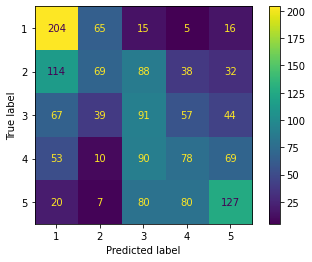

In [219]:
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

array([[<AxesSubplot:title={'center':'intensity'}>]], dtype=object)

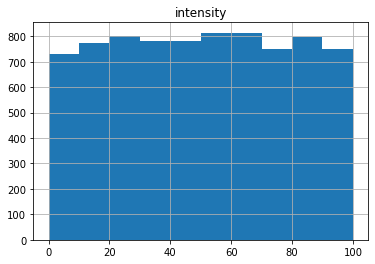

In [220]:
df.hist(column='intensity')

In [221]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

0.21131512392448815

In [222]:
from scipy import stats
stats.spearmanr(y_test, y_pred)

SpearmanrResult(correlation=0.5346999551038434, pvalue=6.304884098009008e-116)